In [1]:
# For plotting
import matplotlib.pyplot as plt
import jax

# To avoid copying things to GPU memory,
# ideally allocate everything in torch on the GPU
# and avoid non-torch function calls
import torch
import numpy as np
import torchquad

from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS # The available integrators
from torchquad.utils.set_precision import set_precision

set_precision('float64')

/Users/ga00693/miniconda3/envs/phd_surrey/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Bsplines

In [2]:
def bspline_basis(j, n, t, x=None):
    # B-spline basis function value B(j,n) at x.
    #
    # Input arguments:
    # j:
    #    interval index, 0 <= j < len(t)-n
    # n:
    #    B-spline order (2 for linear, 3 for quadratic, etc.)
    # t:
    #    knot vector
    # x (optional):
    #    value where the basis function is to be evaluated
    #
    # Output arguments:
    # y:
    #    B-spline basis function value, nonzero for a knot span of n
    
    if x is None:
        x = torch.linspace(t[n-1], t[-n], 100)  # allocate points uniformly

    y = bspline_basis_recurrence(j, n, t, x)
    return y

def bspline_basis_recurrence(j, n, t, x):
    y = torch.zeros_like(x)

    if n > 1:
        b = bspline_basis(j, n-1, t, x)
        dn = x - t[j]
        dd = t[j+n-1] - t[j]

        if dd != 0:  # indeterminate forms 0/0 are deemed to be zero
            y += b * (dn / dd)

        b = bspline_basis(j+1, n-1, t, x)
        dn = t[j+n] - x
        dd = t[j+n] - t[j+1]

        if dd != 0:
            y += b * (dn / dd)
    elif t[j+1] < t[-1]:  # treat last element of knot vector as a special case
        y[(t[j] <= x) & (x < t[j+1])] = 1
    else:
        y[t[j] <= x] = 1
    return y

def bspline_basis_deriv(j, n, t, x=None):
    # B-spline basis function value B(j,n) at x.
    #
    # Input arguments:
    # j:
    #    interval index, 0 <= j < len(t)-n
    # n:
    #    B-spline order (2 for linear, 3 for quadratic, etc.)
    # t:
    #    knot vector
    # x (optional):
    #    value where the basis function is to be evaluated
    #
    # Output arguments:
    # y:
    #    B-spline basis function value, nonzero for a knot span of n
    
    if x is None:
        x = np.linspace(t[n-1], t[-n], 100)  # allocate points uniformly

    y = bspline_basis_recurrence_deriv(j, n, t, x)
    return y

def bspline_basis_recurrence_deriv(j, n, t, x):
    y = torch.zeros_like(x)

    if n > 1:
        b = bspline_basis(j, n-1, t, x)
        dn = 2
        dd = t[j+n-1] - t[j]

        if dd != 0:  # indeterminate forms 0/0 are deemed to be zero
            y += b * (dn / dd)

        b = bspline_basis(j+1, n-1, t, x)
        dn = -2
        dd = t[j+n] - t[j+1]

        if dd != 0:
            y += b * (dn / dd)
    elif t[j+1] < t[-1]:  # treat the last element of the knot vector as a special case
        y[(t[j] <= x) & (x < t[j+1])] = 1
    else:
        y[t[j] <= x] = 1

    return y

def bspline_basis_second_deriv(j, n, t, x=None):
    # B-spline basis function value B(j,n) at x.
    #
    # Input arguments:
    # j:
    #    interval index, 0 <= j < len(t)-n
    # n:
    #    B-spline order (2 for linear, 3 for quadratic, etc.)
    # t:
    #    knot vector
    # x (optional):
    #    value where the basis function is to be evaluated
    #
    # Output arguments:
    # y:
    #    B-spline basis function value, nonzero for a knot span of n
    

    if x is None:
        x = np.linspace(t[n-1], t[-n], 100)  # allocate points uniformly

    y = bspline_basis_recurrence_second_deriv(j, n, t, x)
    return y

def bspline_basis_recurrence_second_deriv(j, n, t, x):
    y = torch.zeros_like(x)

    if n > 2:
        b = bspline_basis(j, n-2, t, x)
        dd = (t[j+n-1] - t[j]) * (t[j+n-2] - t[j])
        dn = 2

        if dd != 0:  # indeterminate forms 0/0 are deemed to be zero
            y += b * (dn / dd)

        b = bspline_basis(j+1, n-2, t, x)
        dn = -2
        dd = (t[j+n-1] - t[j]) * (t[j+n-1] - t[j+1])

        if dd != 0:
            y += b * (dn / dd)

        b = bspline_basis(j+1, n-2, t, x)
        dn = -2
        dd = (t[j+n] - t[j+1]) * (t[j+n-1] - t[j+1])

        if dd != 0:
            y += b * (dn / dd)

        b = bspline_basis(j+2, n-2, t, x)
        dn = 2
        dd = (t[j+n] - t[j+1]) * (t[j+n] - t[j+2])

        if dd != 0:
            y += b * (dn / dd)
    elif t[j+1] < t[-1]:  # treat the last element of the knot vector as a special case
        y[(t[j] <= x) & (x < t[j+1])] = 1
    else:
        y[t[j] <= x] = 1

    return y

In [3]:
# B-spline degree
degree = 3

# Number of points on the curve
num_points = 26
# Example control points (replace with your own data)
knots = np.linspace(0,1,num_points) 

# Interpolate the B-spline curve
curve_points = bspline_basis(20,degree,knots,torch.linspace(0,1,1000))
d_curve_points = bspline_basis_deriv(20,degree,knots,torch.linspace(0,1,1000))
dd_curve_points = bspline_basis_second_deriv(20,degree,knots,torch.linspace(0,1,1000))

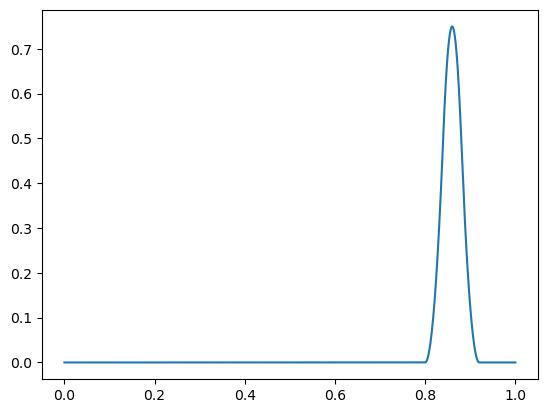

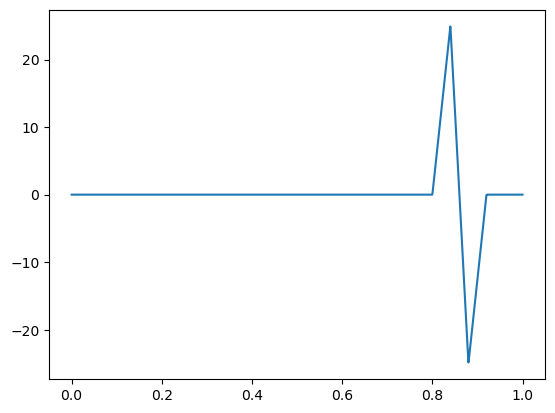

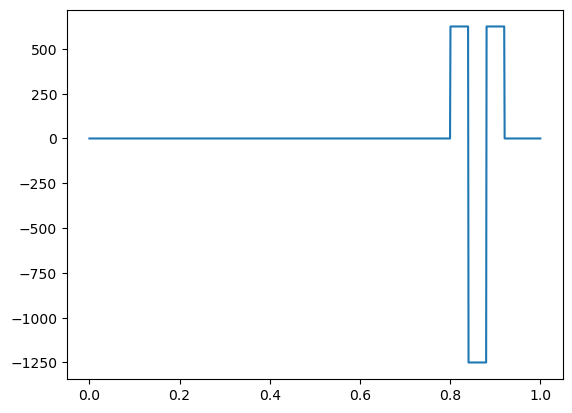

In [4]:
plt.plot(np.linspace(0,1,1000),curve_points)
plt.figure()
plt.plot(np.linspace(0,1,1000),d_curve_points)
plt.figure()
plt.plot(np.linspace(0,1,1000),dd_curve_points)

In [4]:
integration_domain=torch.tensor([[1.041,1.049],[-0.001,0.001],[-0.001,0.001]])


## Multi-Index

In [5]:
type_basis=[3,3,3] #[n+1,n+1,n+1], where n is the order of the basis
n_intervals=[25,25,25] #number of intervals in which the B-spline are constructed (i.e., knot vector) [one x dimension]
nbasis1=n_intervals[0]-type_basis[0]
nbasis2=n_intervals[1]-type_basis[1]
nbasis3=n_intervals[2]-type_basis[2]
nbasis = nbasis1*nbasis2*nbasis3

knots_1=np.linspace(integration_domain[0][0],integration_domain[0][1],n_intervals[0])
knots_2=np.linspace(integration_domain[1][0],integration_domain[1][1],n_intervals[1])
knots_3=np.linspace(integration_domain[2][0],integration_domain[2][1],n_intervals[2])

#x1 = np.linspace(LB_x,UB_x,20)
#x2 = np.linspace(LB_y,UB_y,20)
#x3 = np.linspace(LB_z,UB_z,20)

#X1,X2,X3 = np.meshgrid(a_points,P1_points,P2_points)
#XX = [X1[:], X2[:], X3[:]]
#XX=np.array(XX).reshape(8000,3)
Ind1, Ind2, Ind3 = np.meshgrid(np.arange(nbasis1), np.arange(nbasis2), np.arange(nbasis3))
Indexes = np.column_stack((Ind1.ravel(), Ind3.ravel(), Ind2.ravel()))

## Dynamics

In [4]:
import numpy as np
import pandas as pd
import scipy

#L_file= scipy.io.loadmat('L_quasi_rand_number_1k.mat')
#L_list=np.array(L_file['L']).reshape(len(L_file['L']),)
from numba import njit
@njit
def f_dyn(x,t):
    L_list=np.array([-3.14159265,  0.        , -1.57079633,  1.57079633, -2.35619449,
        0.78539816, -0.78539816,  2.35619449, -2.74889357,  0.39269908,
       -1.17809725,  1.96349541, -1.96349541,  1.17809725, -0.39269908,
        2.74889357, -2.94524311,  0.19634954, -1.37444679,  1.76714587,
       -2.15984495,  0.9817477 , -0.58904862,  2.55254403, -2.55254403,
        0.58904862, -0.9817477 ,  2.15984495, -1.76714587,  1.37444679,
       -0.19634954,  2.94524311, -3.04341788,  0.09817477, -1.47262156,
        1.6689711 , -2.25801972,  0.88357293, -0.68722339,  2.45436926,
       -2.6507188 ,  0.49087385, -1.07992247,  2.06167018, -1.86532064,
        1.27627202, -0.29452431,  2.84706834, -2.84706834,  0.29452431,
       -1.27627202,  1.86532064, -2.06167018,  1.07992247, -0.49087385,
        2.6507188 , -2.45436926,  0.68722339, -0.88357293,  2.25801972,
       -1.6689711 ,  1.47262156, -0.09817477,  3.04341788, -3.09250527,
        0.04908739, -1.52170894,  1.61988371, -2.3071071 ,  0.83448555,
       -0.73631078,  2.40528188, -2.69980619,  0.44178647, -1.12900986,
        2.01258279, -1.91440802,  1.22718463, -0.3436117 ,  2.79798096,
       -2.89615573,  0.24543693, -1.3253594 ,  1.81623325, -2.11075756,
        1.03083509, -0.53996124,  2.60163142, -2.50345665,  0.63813601,
       -0.93266032,  2.20893233, -1.71805848,  1.42353417, -0.14726216,
        2.9943305 , -2.9943305 ,  0.14726216, -1.42353417,  1.71805848,
       -2.20893233,  0.93266032, -0.63813601,  2.50345665, -2.60163142,
        0.53996124, -1.03083509,  2.11075756, -1.81623325,  1.3253594 ,
       -0.24543693,  2.89615573, -2.79798096,  0.3436117 , -1.22718463,
        1.91440802, -2.01258279,  1.12900986, -0.44178647,  2.69980619,
       -2.40528188,  0.73631078, -0.83448555,  2.3071071 , -1.61988371,
        1.52170894, -0.04908739,  3.09250527, -3.11704896,  0.02454369,
       -1.54625263,  1.59534002, -2.3316508 ,  0.80994186, -0.76085447,
        2.38073818, -2.72434988,  0.41724277, -1.15355355,  1.9880391 ,
       -1.93895172,  1.20264094, -0.36815539,  2.77343726, -2.92069942,
        0.22089323, -1.34990309,  1.79168956, -2.13530126,  1.0062914 ,
       -0.56450493,  2.57708772, -2.52800034,  0.61359232, -0.95720401,
        2.18438864, -1.74260218,  1.39899048, -0.17180585,  2.96978681,
       -3.01887419,  0.12271846, -1.44807786,  1.69351479, -2.23347603,
        0.90811663, -0.6626797 ,  2.47891295, -2.62617511,  0.51541754,
       -1.05537878,  2.08621387, -1.84077695,  1.30081571, -0.26998062,
        2.87161203, -2.82252465,  0.319068  , -1.25172832,  1.88986433,
       -2.03712649,  1.10446617, -0.46633016,  2.67526249, -2.42982557,
        0.71176709, -0.85902924,  2.28256341, -1.6444274 ,  1.49716525,
       -0.07363108,  3.06796158, -3.06796158,  0.07363108, -1.49716525,
        1.6444274 , -2.28256341,  0.85902924, -0.71176709,  2.42982557,
       -2.67526249,  0.46633016, -1.10446617,  2.03712649, -1.88986433,
        1.25172832, -0.319068  ,  2.82252465, -2.87161203,  0.26998062,
       -1.30081571,  1.84077695, -2.08621387,  1.05537878, -0.51541754,
        2.62617511, -2.47891295,  0.6626797 , -0.90811663,  2.23347603,
       -1.69351479,  1.44807786, -0.12271846,  3.01887419, -2.96978681,
        0.17180585, -1.39899048,  1.74260218, -2.18438864,  0.95720401,
       -0.61359232,  2.52800034, -2.57708772,  0.56450493, -1.0062914 ,
        2.13530126, -1.79168956,  1.34990309, -0.22089323,  2.92069942,
       -2.77343726,  0.36815539, -1.20264094,  1.93895172, -1.9880391 ,
        1.15355355, -0.41724277,  2.72434988, -2.38073818,  0.76085447,
       -0.80994186,  2.3316508 , -1.59534002,  1.54625263, -0.02454369,
        3.11704896, -3.12932081,  0.01227185, -1.55852448,  1.58306817,
       -2.34392264,  0.79767001, -0.77312632,  2.36846634, -2.73662173,
        0.40497093, -1.1658254 ,  1.97576725, -1.95122356,  1.19036909,
       -0.38042724,  2.76116542, -2.93297127,  0.20862139, -1.36217494,
        1.77941771, -2.1475731 ,  0.99401955, -0.57677678,  2.56481588,
       -2.54027218,  0.60132047, -0.96947586,  2.1721168 , -1.75487402,
        1.38671863, -0.18407769,  2.95751496, -3.03114604,  0.11044662,
       -1.46034971,  1.68124294, -2.24574787,  0.89584478, -0.67495155,
        2.46664111, -2.63844696,  0.5031457 , -1.06765063,  2.07394203,
       -1.85304879,  1.28854386, -0.28225246,  2.85934019, -2.8347965 ,
        0.30679616, -1.26400017,  1.87759248, -2.04939833,  1.09219432,
       -0.47860201,  2.66299065, -2.44209741,  0.69949524, -0.87130109,
        2.27029157, -1.65669925,  1.4848934 , -0.08590292,  3.05568973,
       -3.08023342,  0.06135923, -1.5094371 ,  1.63215556, -2.29483526,
        0.84675739, -0.72403893,  2.41755372, -2.68753434,  0.45405831,
       -1.11673801,  2.02485464, -1.90213618,  1.23945648, -0.33133985,
        2.8102528 , -2.88388388,  0.25770877, -1.31308755,  1.8285051 ,
       -2.09848572,  1.04310694, -0.52768939,  2.61390326, -2.4911848 ,
        0.65040785, -0.92038847,  2.22120418, -1.70578664,  1.43580602,
       -0.13499031,  3.00660234, -2.98205865,  0.159534  , -1.41126232,
        1.73033033, -2.19666049,  0.94493217, -0.62586416,  2.51572849,
       -2.58935957,  0.55223308, -1.01856324,  2.12302941, -1.80396141,
        1.33763125, -0.23316508,  2.90842757, -2.78570911,  0.35588354,
       -1.21491278,  1.92667987, -2.00031095,  1.14128171, -0.42951462,
        2.71207803, -2.39301003,  0.74858262, -0.8222137 ,  2.31937895,
       -1.60761187,  1.53398079, -0.03681554,  3.10477711, -3.10477711,
        0.03681554, -1.53398079,  1.60761187, -2.31937895,  0.8222137 ,
       -0.74858262,  2.39301003, -2.71207803,  0.42951462, -1.14128171,
        2.00031095, -1.92667987,  1.21491278, -0.35588354,  2.78570911,
       -2.90842757,  0.23316508, -1.33763125,  1.80396141, -2.12302941,
        1.01856324, -0.55223308,  2.58935957, -2.51572849,  0.62586416,
       -0.94493217,  2.19666049, -1.73033033,  1.41126232, -0.159534  ,
        2.98205865, -3.00660234,  0.13499031, -1.43580602,  1.70578664,
       -2.22120418,  0.92038847, -0.65040785,  2.4911848 , -2.61390326,
        0.52768939, -1.04310694,  2.09848572, -1.8285051 ,  1.31308755,
       -0.25770877,  2.88388388, -2.8102528 ,  0.33133985, -1.23945648,
        1.90213618, -2.02485464,  1.11673801, -0.45405831,  2.68753434,
       -2.41755372,  0.72403893, -0.84675739,  2.29483526, -1.63215556,
        1.5094371 , -0.06135923,  3.08023342, -3.05568973,  0.08590292,
       -1.4848934 ,  1.65669925, -2.27029157,  0.87130109, -0.69949524,
        2.44209741, -2.66299065,  0.47860201, -1.09219432,  2.04939833,
       -1.87759248,  1.26400017, -0.30679616,  2.8347965 , -2.85934019,
        0.28225246, -1.28854386,  1.85304879, -2.07394203,  1.06765063,
       -0.5031457 ,  2.63844696, -2.46664111,  0.67495155, -0.89584478,
        2.24574787, -1.68124294,  1.46034971, -0.11044662,  3.03114604,
       -2.95751496,  0.18407769, -1.38671863,  1.75487402, -2.1721168 ,
        0.96947586, -0.60132047,  2.54027218, -2.56481588,  0.57677678,
       -0.99401955,  2.1475731 , -1.77941771,  1.36217494, -0.20862139,
        2.93297127, -2.76116542,  0.38042724, -1.19036909,  1.95122356,
       -1.97576725,  1.1658254 , -0.40497093,  2.73662173, -2.36846634,
        0.77312632, -0.79767001,  2.34392264, -1.58306817,  1.55852448,
       -0.01227185,  3.12932081, -3.13545673,  0.00613592, -1.5646604 ,
        1.57693225, -2.35005857,  0.79153409, -0.77926224,  2.36233041,
       -2.74275765,  0.398835  , -1.17196132,  1.96963133, -1.95735949,
        1.18423317, -0.38656316,  2.7550295 , -2.93910719,  0.20248546,
       -1.36831086,  1.77328179, -2.15370903,  0.98788363, -0.5829127 ,
        2.55867995, -2.54640811,  0.59518455, -0.97561178,  2.16598087,
       -1.76100994,  1.38058271, -0.19021362,  2.95137904, -3.03728196,
        0.10431069, -1.46648563,  1.67510702, -2.2518838 ,  0.88970886,
       -0.68108747,  2.46050518, -2.64458288,  0.49700978, -1.07378655,
        2.0678061 , -1.85918471,  1.28240794, -0.28838839,  2.85320427,
       -2.84093242,  0.30066023, -1.27013609,  1.87145656, -2.05553426,
        1.0860584 , -0.48473793,  2.65685472, -2.44823334,  0.69335932,
       -0.87743701,  2.26415564, -1.66283517,  1.47875748, -0.09203885,
        3.04955381, -3.08636935,  0.05522331, -1.51557302,  1.62601964,
       -2.30097118,  0.84062147, -0.73017486,  2.4114178 , -2.69367026,
        0.44792239, -1.12287394,  2.01871872, -1.9082721 ,  1.23332055,
       -0.33747577,  2.80411688, -2.8900198 ,  0.25157285, -1.31922348,
        1.82236918, -2.10462164,  1.03697101, -0.53382531,  2.60776734,
       -2.49732072,  0.64427193, -0.9265244 ,  2.21506826, -1.71192256,
        1.42967009, -0.14112623,  3.00046642, -2.98819457,  0.15339808,
       -1.41739825,  1.72419441, -2.20279641,  0.93879624, -0.63200008,
        2.50959257, -2.59549549,  0.54609716, -1.02469917,  2.11689349,
       -1.81009733,  1.33149532, -0.239301  ,  2.90229165, -2.79184503,
        0.34974762, -1.22104871,  1.92054395, -2.00644687,  1.13514578,
       -0.43565054,  2.70594211, -2.39914595,  0.7424467 , -0.82834963,
        2.31324303, -1.61374779,  1.52784486, -0.04295146,  3.09864119,
       -3.11091304,  0.03067962, -1.54011671,  1.60147594, -2.32551487,
        0.81607778, -0.75471855,  2.38687411, -2.71821396,  0.4233787 ,
       -1.14741763,  1.99417502, -1.93281579,  1.20877686, -0.36201947,
        2.77957319, -2.9145635 ,  0.22702916, -1.34376717,  1.79782548,
       -2.12916533,  1.01242732, -0.55836901,  2.58322365, -2.52186442,
        0.61972824, -0.95106809,  2.19052457, -1.73646625,  1.4051264 ,
       -0.16566993,  2.97592273, -3.01273827,  0.12885439, -1.44194194,
        1.69965071, -2.2273401 ,  0.91425255, -0.65654378,  2.48504888,
       -2.62003919,  0.52155347, -1.04924286,  2.09234979, -1.83464102,
        1.30695163, -0.2638447 ,  2.87774796, -2.81638873,  0.32520393,
       -1.2455924 ,  1.89600025, -2.03099056,  1.11060209, -0.46019424,
        2.68139842, -2.42368964,  0.71790301, -0.85289332,  2.28869934,
       -1.63829148,  1.50330117, -0.06749515,  3.0740975 , -3.06182565,
        0.079767  , -1.49102933,  1.65056333, -2.27642749,  0.86516516,
       -0.70563116,  2.43596149, -2.66912657,  0.47246608, -1.09833024,
        2.04326241, -1.88372841,  1.25786425, -0.31293208,  2.82866057,
       -2.86547611,  0.27611654, -1.29467978,  1.84691287, -2.08007795,
        1.06151471, -0.50928162,  2.63231103, -2.47277703,  0.66881562,
       -0.9019807 ,  2.23961195, -1.68737887,  1.45421379, -0.11658254,
        3.02501011, -2.96365088,  0.17794177, -1.39285456,  1.7487381 ,
       -2.17825272,  0.96333993, -0.60745639,  2.53413626, -2.5709518 ,
        0.57064085, -1.00015547,  2.14143718, -1.78555364,  1.35603902,
       -0.21475731,  2.92683534, -2.76730134,  0.37429131, -1.19650501,
        1.94508764, -1.98190318,  1.15968948, -0.41110685,  2.7304858 ,
       -2.37460226,  0.76699039, -0.80380593,  2.33778672, -1.5892041 ,
        1.55238856, -0.01840777,  3.12318488, -3.12318488,  0.01840777,
       -1.55238856,  1.5892041 , -2.33778672,  0.80380593, -0.76699039,
        2.37460226, -2.7304858 ,  0.41110685, -1.15968948,  1.98190318,
       -1.94508764,  1.19650501, -0.37429131,  2.76730134, -2.92683534,
        0.21475731, -1.35603902,  1.78555364, -2.14143718,  1.00015547,
       -0.57064085,  2.5709518 , -2.53413626,  0.60745639, -0.96333993,
        2.17825272, -1.7487381 ,  1.39285456, -0.17794177,  2.96365088,
       -3.02501011,  0.11658254, -1.45421379,  1.68737887, -2.23961195,
        0.9019807 , -0.66881562,  2.47277703, -2.63231103,  0.50928162,
       -1.06151471,  2.08007795, -1.84691287,  1.29467978, -0.27611654,
        2.86547611, -2.82866057,  0.31293208, -1.25786425,  1.88372841,
       -2.04326241,  1.09833024, -0.47246608,  2.66912657, -2.43596149,
        0.70563116, -0.86516516,  2.27642749, -1.65056333,  1.49102933,
       -0.079767  ,  3.06182565, -3.0740975 ,  0.06749515, -1.50330117,
        1.63829148, -2.28869934,  0.85289332, -0.71790301,  2.42368964,
       -2.68139842,  0.46019424, -1.11060209,  2.03099056, -1.89600025,
        1.2455924 , -0.32520393,  2.81638873, -2.87774796,  0.2638447 ,
       -1.30695163,  1.83464102, -2.09234979,  1.04924286, -0.52155347,
        2.62003919, -2.48504888,  0.65654378, -0.91425255,  2.2273401 ,
       -1.69965071,  1.44194194, -0.12885439,  3.01273827, -2.97592273,
        0.16566993, -1.4051264 ,  1.73646625, -2.19052457,  0.95106809,
       -0.61972824,  2.52186442, -2.58322365,  0.55836901, -1.01242732,
        2.12916533, -1.79782548,  1.34376717, -0.22702916,  2.9145635 ,
       -2.77957319,  0.36201947, -1.20877686,  1.93281579, -1.99417502,
        1.14741763, -0.4233787 ,  2.71821396, -2.38687411,  0.75471855,
       -0.81607778,  2.32551487, -1.60147594,  1.54011671, -0.03067962,
        3.11091304, -3.09864119,  0.04295146, -1.52784486,  1.61374779,
       -2.31324303,  0.82834963, -0.7424467 ,  2.39914595, -2.70594211,
        0.43565054, -1.13514578,  2.00644687, -1.92054395,  1.22104871,
       -0.34974762,  2.79184503, -2.90229165,  0.239301  , -1.33149532,
        1.81009733, -2.11689349,  1.02469917, -0.54609716,  2.59549549,
       -2.50959257,  0.63200008, -0.93879624,  2.20279641, -1.72419441,
        1.41739825, -0.15339808,  2.98819457, -3.00046642,  0.14112623,
       -1.42967009,  1.71192256, -2.21506826,  0.9265244 , -0.64427193,
        2.49732072, -2.60776734,  0.53382531, -1.03697101,  2.10462164,
       -1.82236918,  1.31922348, -0.25157285,  2.8900198 , -2.80411688,
        0.33747577, -1.23332055,  1.9082721 , -2.01871872,  1.12287394,
       -0.44792239,  2.69367026, -2.4114178 ,  0.73017486, -0.84062147,
        2.30097118, -1.62601964,  1.51557302, -0.05522331,  3.08636935,
       -3.04955381,  0.09203885, -1.47875748,  1.66283517, -2.26415564,
        0.87743701, -0.69335932,  2.44823334, -2.65685472,  0.48473793,
       -1.0860584 ,  2.05553426, -1.87145656,  1.27013609, -0.30066023,
        2.84093242, -2.85320427,  0.28838839, -1.28240794,  1.85918471,
       -2.0678061 ,  1.07378655, -0.49700978,  2.64458288, -2.46050518,
        0.68108747, -0.88970886,  2.2518838 , -1.67510702,  1.46648563,
       -0.10431069,  3.03728196, -2.95137904,  0.19021362, -1.38058271,
        1.76100994, -2.16598087,  0.97561178, -0.59518455,  2.54640811])
    DU=6378.136 #distance unit DU - Earth Radius [km]
    TU=60*60*24 #806.78 #time unit TU
    years=1 #integration years
    days=365 #integration days
    t0=0 #initial integration time
    tf=3600*24*days*years/TU #final integration time
    #Earth gravitational constant and radius:
    mu_e=3.986*1e14*1e-9/DU**3*TU**2
    R_e = 6378.136/DU

    #upper and lower integration bounds:
    LB_x=1.041#6600/DU
    LB_y=-0.001
    LB_z=-0.001
    UB_x=1.049#6750/DU
    UB_y=0.001
    UB_z=0.001
    
    R_e = 6378.136/DU
    mu_e=3.986*1e14*1e-9/DU**3*TU**2
    m=200
    A=50*1e-6/(DU**2)
    Cd=2
    
    cos_L_list=np.cos(L_list)
    sin_L_list=np.sin(L_list)

    a=x[0]
    P1=x[1]
    P2=x[2]

    B=np.sqrt(1-P1**2-P2**2)
    b=a*B
    n=np.sqrt(mu_e/(a**3))
    h_factor=n*a*b
    #print(f'shape P2:{P2.shape}')
    #print(f'shape sinL:{sin_L_list.shape}')
    D=np.sqrt(1+P1**2+P2**2+2*(P2*cos_L_list+P1*sin_L_list))
    p_r=1+P1*sin_L_list+P2*cos_L_list
    #print(p_r)

    r_h=h_factor/(mu_e*(1+P1*sin_L_list+P2*cos_L_list))
    Phi=1+P1*sin_L_list+P2*cos_L_list
    p=a*(1-(P1**2+P2**2))
    rho=1.225*np.exp(-(p/Phi-R_e-0.)*DU/7.249)*1e9*DU**3

    a_r=-0.5 * rho * Cd * A/m * ( mu_e / a ) * (2 * Phi / B**2 - 1) * (P2 * sin_L_list - P1 * cos_L_list) / D
    a_theta=-0.5 * rho * Cd * A/m * ( mu_e / a ) * (2 * Phi / B**2 - 1) * (1+P1*sin_L_list+P2*cos_L_list) / D 
    #I=jnp.sum(r_h*(-p_r*cos_L_list*a_r+(P1+(1+p_r)*sin_L_list)*a_theta)*((1-P1**2-P2**2)/(1+P1*sin_L_list+P2*cos_L_list))**2*1/(np.sqrt(1-P1**2-P2**2)))
    da_dt=np.sum(2*a**2/h_factor* ( (P2*sin_L_list-P1*cos_L_list)*a_r + p_r*a_theta)*((1-P1**2-P2**2)/(1+P1*sin_L_list+P2*cos_L_list))**2*1/(np.sqrt(1-P1**2-P2**2)))/len(sin_L_list)#*2*np.pi
    dP1_dt=np.sum(r_h*(-p_r*cos_L_list*a_r+(P1+(1+p_r)*sin_L_list)*a_theta)*((1-P1**2-P2**2)/(1+P1*sin_L_list+P2*cos_L_list))**2*1/(np.sqrt(1-P1**2-P2**2)))/len(sin_L_list)#*2*np.pi
    dP2_dt=np.sum(r_h*(p_r*sin_L_list*a_r+(P2+(1+p_r)*cos_L_list)*a_theta)*((1-P1**2-P2**2)/(1+P1*sin_L_list+P2*cos_L_list))**2*1/(np.sqrt(1-P1**2-P2**2)))/len(sin_L_list)#*2*np.pi
    return np.asarray(
        [da_dt,
         dP1_dt,
         dP2_dt])

@njit
def G(x, t):
    return np.array([[0.,0.,0.],[0.,1e-5/8,0.],[0.,0.,0.]])#np.array([[0.0,0.0], [0.0, 0.0]])#np.sqrt(2.0*sigma)]])


## Computing the extra diffusion term:

That is:
$\bigg\langle \Phi_{i}, \sum_{kl}\dfrac{\partial^2 D_{kl}\Phi_j}{\partial x_k \partial x_l}\bigg\rangle$


In [35]:
d_lk=(1e-5/8)**2/2

In [39]:
MC_samples=int(1e4)
trpz=Trapezoid()
integrate_jit_compiled_parts=trpz.get_jit_compiled_integrate(1,MC_samples,backend='torch')

diff_terms=torch.zeros((len(Indexes),len(Indexes)))
for i in tqdm(range(len(Indexes))):

    basis_a_i  = lambda x: bspline_basis(Indexes[i][0],3,knots_1,x)
    basis_P1_i  = lambda x: bspline_basis(Indexes[i][1],3,knots_2,x)
    basis_P2_i = lambda x: bspline_basis(Indexes[i][2],3,knots_3,x)
    
    for j in range(len(Indexes)):
        if max(abs(Indexes[i]-Indexes[j]))<3:
            basis_a_j   = lambda x: bspline_basis(Indexes[j][0],3,knots_1,x)
            basis_P1_j   = lambda x: bspline_basis(Indexes[j][1],3,knots_2,x)
            basis_P2_j  = lambda x: bspline_basis(Indexes[j][2],3,knots_3,x)
            
            
            basis_ddP1_j  = lambda x: bspline_basis_second_deriv(Indexes[j][1],3,knots_2,x)
            int_a_a=integrate_jit_compiled_parts(lambda x: basis_a_i(x)*basis_a_j(x), integration_domain[0].unsqueeze(0))
            int_P1_ddP1=integrate_jit_compiled_parts(lambda x: basis_P1_i(x)*basis_ddP1_j(x), integration_domain[1].unsqueeze(0))
            int_P2_P2=integrate_jit_compiled_parts(lambda x: basis_P2_i(x)*basis_P2_j(x), integration_domain[2].unsqueeze(0))
            diff_terms[i,j]=int_P1_ddP1*int_a_a*int_P2_P2*d_lk            


            

  0%|                                                   | 0/10648 [00:00<?, ?it/s]/Users/ga00693/miniconda3/envs/phd_surrey/lib/python3.8/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
100%|███████████████████████████████████████| 10648/10648 [36:29<00:00,  4.86it/s]


In [43]:
#np.save('diff_terms_matrix',diff_terms)

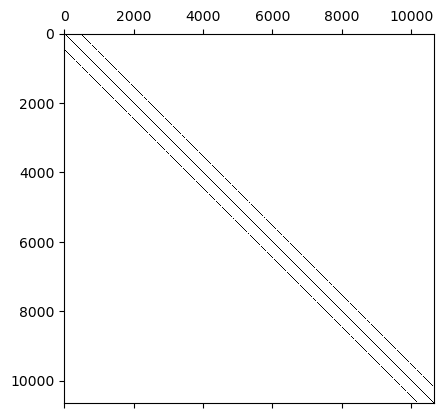

In [16]:
plt.spy(diff_terms_matrix)

In [44]:
import scipy
import scipy.io
IntM=scipy.io.loadmat('Int_Matrix_QMC.mat')['Int']
IntM=IntM.todense()

In [45]:
InnerProdPhi=scipy.io.loadmat('InnerProdPhi.mat')['InnerProdPhi']
InnerProdPhi=InnerProdPhi.todense()

In [53]:
IntM_diffusive=IntM+diff_terms

## Initial a

$a_{0,k}=\langle \Phi_k, p(x,t_0) \rangle$

In [10]:
mean=[1.045,0.0,0.0]
cov=[[(0.5*1e-3)**2, 0.0, 0.0],[0.0, (1e-4)**2,0.0], [0.0, 0.0, (1e-4)**2]]

multivar=torch.distributions.MultivariateNormal(loc=torch.tensor(mean),covariance_matrix=torch.tensor(cov))

# Define a function that evaluates the PDF of the Gaussian distribution at a given point x
def mvn_pdf(x):
    return torch.exp(multivar.log_prob(x))

In [11]:
MC_samples=int(1e5)
trpz=Trapezoid()
integrate_jit_compiled_parts_3d=trpz.get_jit_compiled_integrate(3,MC_samples,backend='torch')
integrate_jit_compiled_parts=trpz.get_jit_compiled_integrate(1,int(1e4),backend='torch')

In [49]:
from tqdm import tqdm
a_0k=[]
Phi_i=[]
for i in tqdm(range(len(Indexes))):
    basis_a_i  = lambda x: bspline_basis(Indexes[i][0],3,knots_1,x)
    basis_P1_i  = lambda x: bspline_basis(Indexes[i][1],3,knots_2,x)
    basis_P2_i = lambda x: bspline_basis(Indexes[i][2],3,knots_3,x)

    Phi_i.append(lambda x: basis_a_i(x[:,0])*basis_P1_i(x[:,1])*basis_P2_i(x[:,2])*mvn_pdf(x))
    v=integrate_jit_compiled_parts_3d(Phi_i[-1],integration_domain)
    a_0k.append(v)
a_0k=np.array(a_0k)     
a_0k=np.linalg.solve(InnerProdPhi,a_0k)


100%|███████████████████████████████████████| 10648/10648 [08:24<00:00, 21.09it/s]


In [54]:
# I compute the expm
expm=np.linalg.solve(InnerProdPhi,IntM_diffusive)
#and now the a_coefficients
a_t=[]
for i in tqdm(np.linspace(0,50*365,51)):
    a_t.append(np.matmul(scipy.linalg.expm(expm*i),a_0k))
    np.save(f'a_t_diffusive_{i}',a_t[-1])
    

100%|██████████████████████████████████████████| 51/51 [1:47:01<00:00, 125.92s/it]


In [6]:
from tqdm import tqdm
a_t=[]
for i in tqdm(np.linspace(0,50*365,51)):
    a_t.append(np.load(f'a_t_diffusive_{i}.npy'))

100%|████████████████████████████████████████████| 51/51 [00:00<00:00, 131.71it/s]


In [7]:
def pdf_approx_integral(Indexes,a_coeff):
    pdf_approx_integral=0
    for i in range(len(Indexes)):
        v1=integrate_jit_compiled_parts(lambda x: bspline_basis(Indexes[i][0],3,knots_1,x),integration_domain[0].unsqueeze(0))
        v2=integrate_jit_compiled_parts(lambda x: bspline_basis(Indexes[i][1],3,knots_2,x),integration_domain[1].unsqueeze(0))
        v3=integrate_jit_compiled_parts(lambda x: bspline_basis(Indexes[i][2],3,knots_3,x),integration_domain[2].unsqueeze(0))
        pdf_approx_integral+=a_coeff[i]*v1*v2*v3
    return pdf_approx_integral

def pdf_approx_mean(Indexes,a_coeff):
    mean_a=0
    mean_P1=0
    mean_P2=0
    for i in range(len(Indexes)):
        v1=integrate_jit_compiled_parts(lambda x: bspline_basis(Indexes[i][0],3,knots_1,x),integration_domain[0].unsqueeze(0))
        v2=integrate_jit_compiled_parts(lambda x: bspline_basis(Indexes[i][1],3,knots_2,x),integration_domain[1].unsqueeze(0))
        v3=integrate_jit_compiled_parts(lambda x: bspline_basis(Indexes[i][2],3,knots_3,x),integration_domain[2].unsqueeze(0))
        v1a=integrate_jit_compiled_parts(lambda x: x*bspline_basis(Indexes[i][0],3,knots_1,x),integration_domain[0].unsqueeze(0))
        v2P1=integrate_jit_compiled_parts(lambda x: x*bspline_basis(Indexes[i][1],3,knots_2,x),integration_domain[1].unsqueeze(0))
        v3P2=integrate_jit_compiled_parts(lambda x: x*bspline_basis(Indexes[i][2],3,knots_3,x),integration_domain[2].unsqueeze(0))
        mean_a+=a_coeff[i]*v1a*v2*v3
        mean_P1+=a_coeff[i]*v1*v2P1*v3
        mean_P2+=a_coeff[i]*v1*v2*v3P2
    return [mean_a,mean_P1,mean_P2]

In [8]:
from scipy.stats import qmc
sampler = qmc.Halton(d=3,scramble=False)
halton_samples_3d = sampler.random(n=3500000)
halton_samples_3d = qmc.scale(halton_samples_3d,integration_domain[:,0].numpy(),integration_domain[:,1].numpy())


In [9]:
def pdf_approx(x, Indexes, a_coeff):
    pdf_approx=0
    for i in range(len(Indexes)):
        pdf_approx+=a_coeff[i]*bspline_basis(Indexes[i][0],3,knots_1,x[:,0]).numpy()*bspline_basis(Indexes[i][1],3,knots_2,x[:,1]).numpy()*bspline_basis(Indexes[i][2],3,knots_3,x[:,2]).numpy()
    return pdf_approx

In [102]:
means=np.array(means)
np.save('means_w_diffusion',means)

In [134]:
integrals=[]
for i in tqdm(range(31)):
    integrals.append(pdf_approx_integral(Indexes,a_t[i]))
integrals=np.array(integrals)
np.save("integrals_diff",integrals)

100%|█████████████████████████████████████████████| 31/31 [05:06<00:00,  9.89s/it]


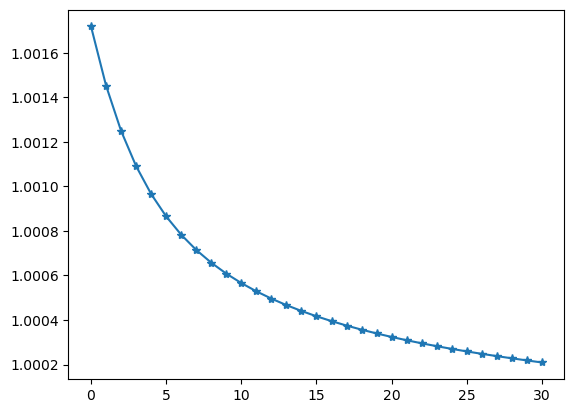

In [138]:
plt.plot(integrals,'-*')

In [10]:
def compute_hellinger(p,q):
    val=0
    for i in range(len(p)):
        val+=(np.sqrt(p[i])-np.sqrt(q[i]))**2
    return 1/np.sqrt(2)*np.sqrt(val)

def compute_kl(p,q):
    kl_div=0
    for i in range(len(p)):
        kl_div+=p[i]*np.log(p[i]/q[i])
    return kl_div